# Machine Learning Exam, 30.04.2017

### Author: S. Paskalev 

** Task: ** By using the Linear Regression modeling we will try to find the relationship between variables in drills minerals dataset, and predict values like length of drills and longitude

The below dataset is officially published from the goverment of Ontario. The initial format was access (.mdb) which was converted to mysql, and from this database was generated a csv file including data from 3 db tables.

** Source: ** http://www.geologyontario.mndm.gov.on.ca/

** Info: **  <a href="http://localhost:8888/edit/jupyter%20files/ML_final%20exam/coursework-topic">Link</a>

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math

import scipy.stats
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.linear_model import RANSACRegressor



### 1. Data exploration

Loading the data from the file and checking its dimensions

In [2]:
loaded_data = pd.read_csv("files/drill_data.csv")
loaded_data.shape

(21480, 28)

In [3]:
drills_data = loaded_data[['MNDM_HOLE_ID', 'TWP_AREA_NUM', 'HOLE_TYPE_CD', 'LAT_DG', 'LAT_MIN', 'LAT_SEC', 
                           'LONG_DG', 'LONG_MIN', 'LONG_SEC', 'AZIMUTH', 'OVERBURDEN','LENGTH', 'DIP', 
                           'YEAR_DRILLED', 'ELEMENT_CODE', 'ELEMENT_DESCRIPTION']].copy()

drills_data.columns = ['hole_id', 'area_num', 'hole_type', 'lat_dg', 'lat_min', 'lat_sec',
                       'long_dg', 'long_min', 'long_sec', 'azimuth', 'overburden', 'length', 'drill_angle', 
                       'year', 'element_code', 'element_description']
drills_data.head()

,hole_id,area_num,hole_type,lat_dg,lat_min,lat_sec,long_dg,long_min,long_sec,azimuth,overburden,length,drill_angle,year,element_code,element_description
0,981,4754,DD,52.0,36.0,40.43,-90.0,22.0,1.42,47,25.55,287,-53,1987,AU,Presence of gold: At least 3000 ppb
1,982,4754,DD,52.0,36.0,37.72,-90.0,21.0,47.15,38,12.2,137,-51,1987,AU,Presence of gold: At least 3000 ppb
2,983,4754,DD,52.0,36.0,37.98,-90.0,21.0,46.64,38,12.5,122,-50,1987,AU,Presence of gold: At least 3000 ppb
3,984,4754,DD,52.0,36.0,36.39,-90.0,21.0,45.59,38,25.4,172,-50,1987,AU,Presence of gold: At least 3000 ppb
4,986,4754,DD,52.0,36.0,42.87,-90.0,21.0,42.85,218,20,266,-53,1987,AU,Presence of gold: At least 3000 ppb


In [4]:
code2description = drills_data.groupby(['element_code','element_description']).size().reset_index().rename(columns={0:'count'})
code2description

,element_code,element_description,count
0,AG,Presence of silver: At least 35 grams per ton,576
1,AU,Presence of gold: At least 3000 ppb,9698
2,AU5,Presence of Gold: Between 500 and 3000 ppb,7015
3,CU,Presence of copper: At least 0.1%,2064
4,NI,Presence of nickel: At least 0.1%,727
5,PB,Presence of lead: At least 1.0%,93
6,PGE,Presence of platinum group elements: At least ...,327
7,ZN,Presence of zinc: At least 0.25%,979


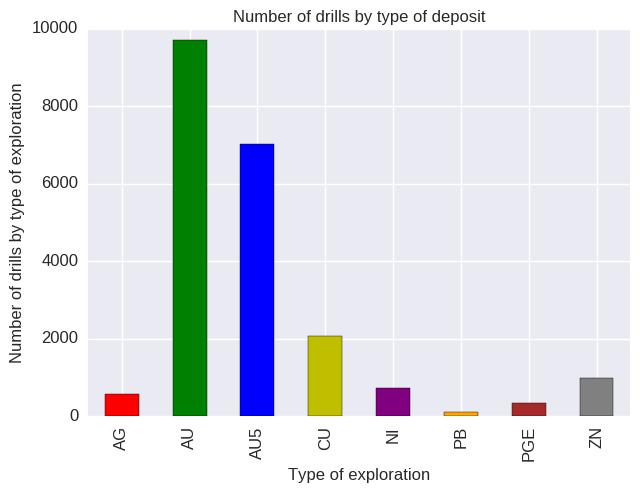

In [5]:
#code2description.dropna(how='any')

#colors = ['green', 'blue', 'cyan', 'magenta','red', 'green', 'blue']
color_list = ['r', 'g', 'b', 'y','purple','orange','brown','grey']
ax = code2description[['count']].plot(kind='bar', color=color_list, figsize=(7, 5), fontsize=12, legend=False)

ax.set_xticklabels(code2description['element_code'], rotation=90)
ax.set_title("Number of drills by type of deposit", fontsize=12)
ax.set_xlabel("Type of exploration", fontsize=12)
ax.set_ylabel("Number of drills by type of exploration", fontsize=12)

plt.show()

Creation of a new fetures "latitude" and "longitude", by convertion of degrees, minutes, and seconds

In [6]:
def convert_lat_lond(Degrees,Minutes,Seconds):
    lat_or_long = np.where(drills_data.lat_dg > 0, 
                    (Seconds/3600) + (Minutes/60) + Degrees, 
                   -(Seconds/3600) - (Minutes/60) + Degrees) # if the degrees value is negative
    
    return lat_or_long

drills_data['latitude'] = convert_lat_lond(drills_data.lat_dg, drills_data.lat_min, drills_data.lat_sec)
drills_data['longitude'] = convert_lat_lond(drills_data.long_dg, drills_data.long_min, drills_data.long_sec)

Filtering the data and getting only specific features

In [7]:
drills_data = drills_data.filter(['area_num',"length", "latitude", "longitude", "lat_long", "overburden", 
                                  "azimuth", "drill_angle", "element_code", "hole_type"], axis=1)

Checking the datatypes. Some of them need convertion to numeric types. Removing observations(rows) where we have NaN values 

In [8]:
drills_data.dtypes

area_num          int64
length           object
latitude        float64
longitude       float64
overburden       object
azimuth          object
drill_angle      object
element_code     object
hole_type        object
dtype: object

In [9]:
drills_data["azimuth"] = pd.to_numeric(drills_data["azimuth"], errors='coerce')
drills_data["overburden"] = pd.to_numeric(drills_data["overburden"], errors='coerce')
drills_data["length"] = pd.to_numeric(drills_data["length"], errors='coerce')
drills_data["drill_angle"] = pd.to_numeric(drills_data["drill_angle"], errors='coerce')

In [10]:
drills_data = drills_data.dropna(how='any')

Again, checking the features and observations we can see they are sslightly reduced

In [11]:
drills_data.shape

(12417, 9)

In [12]:
drills_data.head()

,area_num,length,latitude,longitude,overburden,azimuth,drill_angle,element_code,hole_type
0,4754,287.0,52.611231,-89.632939,25.55,47.0,-53.0,AU,DD
1,4754,137.0,52.610478,-89.636903,12.20,38.0,-51.0,AU,DD
2,4754,122.0,52.610550,-89.637044,12.50,38.0,-50.0,AU,DD
3,4754,172.0,52.610108,-89.637336,25.40,38.0,-50.0,AU,DD
4,4754,266.0,52.611908,-89.638097,20.00,218.0,-53.0,AU,DD


Additional filter is applied, for now the features "element_code" and "hole_type" are not necessary

In [13]:
drills_data = drills_data.filter(['area_num',"length", "latitude", "longitude", "overburden", "azimuth"], axis=1)

All the drills operations are concerning specific area. This can be identified with the "area_num" feature.

Having the above prerequisite are made some modifications of the dataset:
- summing by feature (length, latitude, longitude, overburden, azimuth, holes), grouped by "area_num"
- new feture "holes", representing number of drills/holes for each area
- reseting the index and removing the "area_num" 

In [14]:
drills = drills_data.groupby([drills_data.area_num]).sum()

#create holes number column
drills["holes"] = drills_data.groupby([drills_data.area_num]).count()["length"]

#reset index
drills = drills.reset_index(drop=True)

drills.head()

,length,latitude,longitude,overburden,azimuth,holes
0,782.01,294.771628,-469.418861,98.46,1086.0,6
1,25117.00,9019.094767,-15592.579367,503.36,32367.0,187
2,982.62,294.464106,-469.999569,37.80,1285.0,6
3,2979.87,580.154281,-968.921522,399.84,3156.0,12
4,3687.47,1407.804828,-2390.416236,35.57,7849.0,30


Calculating the mean of the "length", "latitude", "longitude", "overburden", "azimuth" by dividing their values of the number of the holes

In [15]:
def recalc_columns(df, col_name, divisor_col_name):
    df[col_name] = df[col_name]/df[divisor_col_name]

recalc_columns(drills, "length", "holes")
recalc_columns(drills, "latitude", "holes")
recalc_columns(drills, "longitude", "holes")

recalc_columns(drills, "overburden", "holes")
recalc_columns(drills, "azimuth", "holes")

drills.head()

,length,latitude,longitude,overburden,azimuth,holes
0,130.335000,49.128605,-78.236477,16.410000,181.000000,6
1,134.315508,48.230453,-83.382777,2.691765,173.085561,187
2,163.770000,49.077351,-78.333262,6.300000,214.166667,6
3,248.322500,48.346190,-80.743460,33.320000,263.000000,12
4,122.915667,46.926828,-79.680541,1.185667,261.633333,30


We can take the maximum length of a drills and can see how much it will cost for the company perform drilling activities.

In [16]:
print("The maximum length in meters for a specific drills exploration is {:.2f}".format(drills.length.values.max()))
print("Having that the average amount for drilling operations by meter is 1500")
print("We know that the tolal cost for the company in this case is: {} USD".format(drills.length.values.max() * 1500))

The maximum length in meters for a specific drills exploration is 1118.29
Having that the average amount for drilling operations by meter is 1500
We know that the tolal cost for the company in this case is: 1677435.0 USD


Reordering the columns

In [17]:
drills = drills[['overburden', 'azimuth', 'holes', 'length', 'latitude', 'longitude']]

Finding and plotting the mean of the total drill length

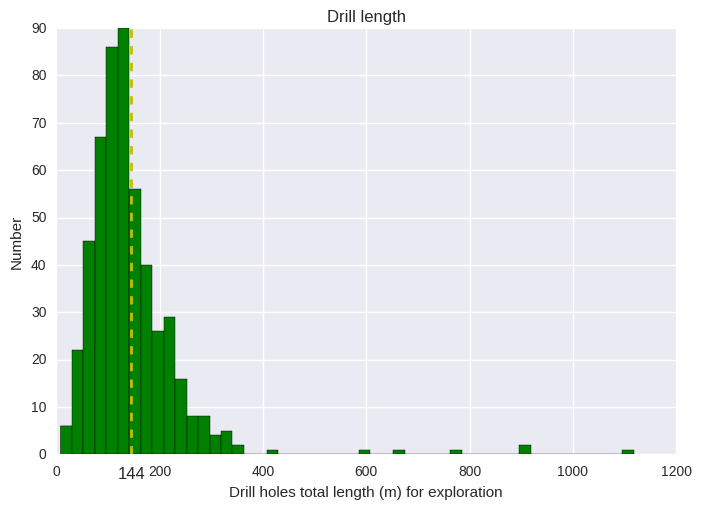

In [18]:
plt.hist(drills.length, bins=50, color='g')
# plt.axvline(drills.length.mean(), 0, 35, color = "red", label = "Mean length")
plt.axvline(drills.length.mean(), color='y', linestyle='dashed', linewidth=2)
plt.text(120, -5, str(int(drills.length.mean())))
plt.xlabel('Drill holes total length (m) for exploration')
plt.ylabel('Number')
plt.title('Drill length')

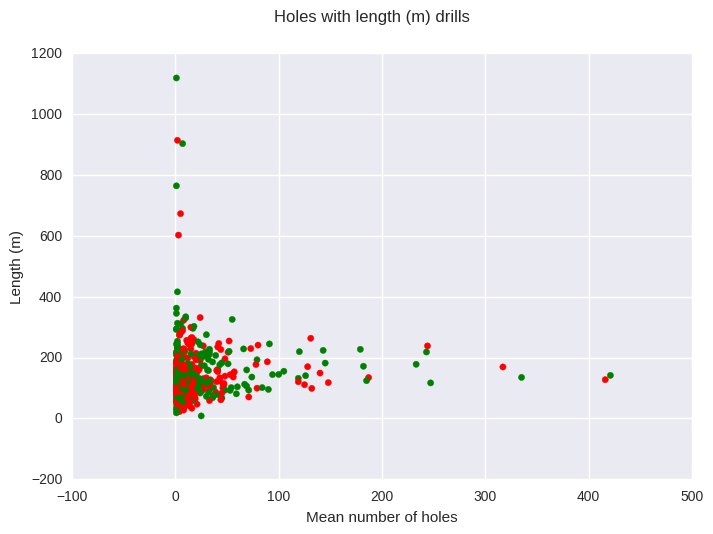

In [19]:
plt.scatter(drills.holes, drills.length, color='gr')
plt.suptitle("Holes with length (m) drills")
plt.xlabel("Mean number of holes")
plt.ylabel("Length (m)")
plt.show()

Checking correlations based on Pearson's correlation coefficient. Example given below for correlation between all features.

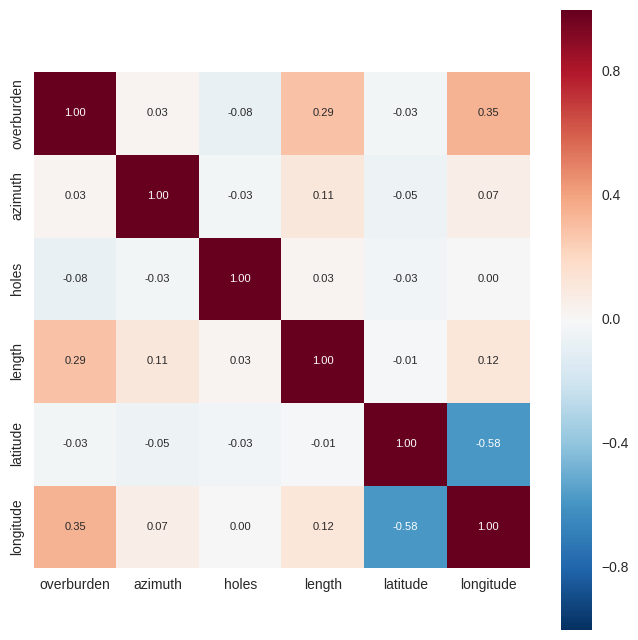

In [20]:
#drills.corr()
plt.figure(figsize=(8,8))

sns.heatmap(drills.corr(), annot=True, fmt=".2f", annot_kws={"size": 8}, square = True)
plt.show()

Creation of drills model. Removing longitude as attribute from the training data (otherwise we will have corellation 1)

In [21]:
drills_model = LinearRegression()
drills_model.fit(drills.drop("longitude", axis=1), drills.longitude)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
print(drills_model.coef_, drills_model.intercept_)

[  1.21119106e-01   1.88747126e-03   9.30047992e-04   7.50221658e-04
  -2.12961614e+00] 17.7974854407


The intercept is 17.80

To test we get a random 5 drills data

In [23]:
indices = np.random.randint(0, len(drills), 5)  # get random indices from drills dataset
drills_sample = drills.ix[indices]
drills_sample

,overburden,azimuth,holes,length,latitude,longitude
421,2.130000,195.000000,1,57.010000,49.558678,-84.272950
192,3.287391,211.608696,69,106.107536,46.849169,-79.363560
328,32.131071,276.285714,28,173.012500,49.835028,-78.403047
27,2.360000,345.000000,4,97.102500,48.763746,-91.507363
321,0.715000,225.000000,8,27.537500,49.803668,-91.269368


In [24]:
predicted5 = drills_model.predict(drills_sample.drop("longitude", axis = 1))
print(predicted5)
print(drills_sample.longitude)

[-87.073734   -81.03191167 -83.76298693 -85.03698761 -87.72582922]
421   -84.272950
192   -79.363560
328   -78.403047
27    -91.507363
321   -91.269368
Name: longitude, dtype: float64


In [25]:
diff_sum = []
for i,v in enumerate(drills_sample.longitude):
    diff = ((v - predicted5[i]) / v) * 100

    diff_sum.append(diff)
    print("Real: {:.2f}, Predicted: {:.2f}, Difference: {:.2f}%".format(v, predicted5[i], diff))

Real: -84.27, Predicted: -87.07, Difference: -3.32%
Real: -79.36, Predicted: -81.03, Difference: -2.10%
Real: -78.40, Predicted: -83.76, Difference: -6.84%
Real: -91.51, Predicted: -85.04, Difference: 7.07%
Real: -91.27, Predicted: -87.73, Difference: 3.88%


Trying to plot the predicted and real coordinates on the map and to see the difference

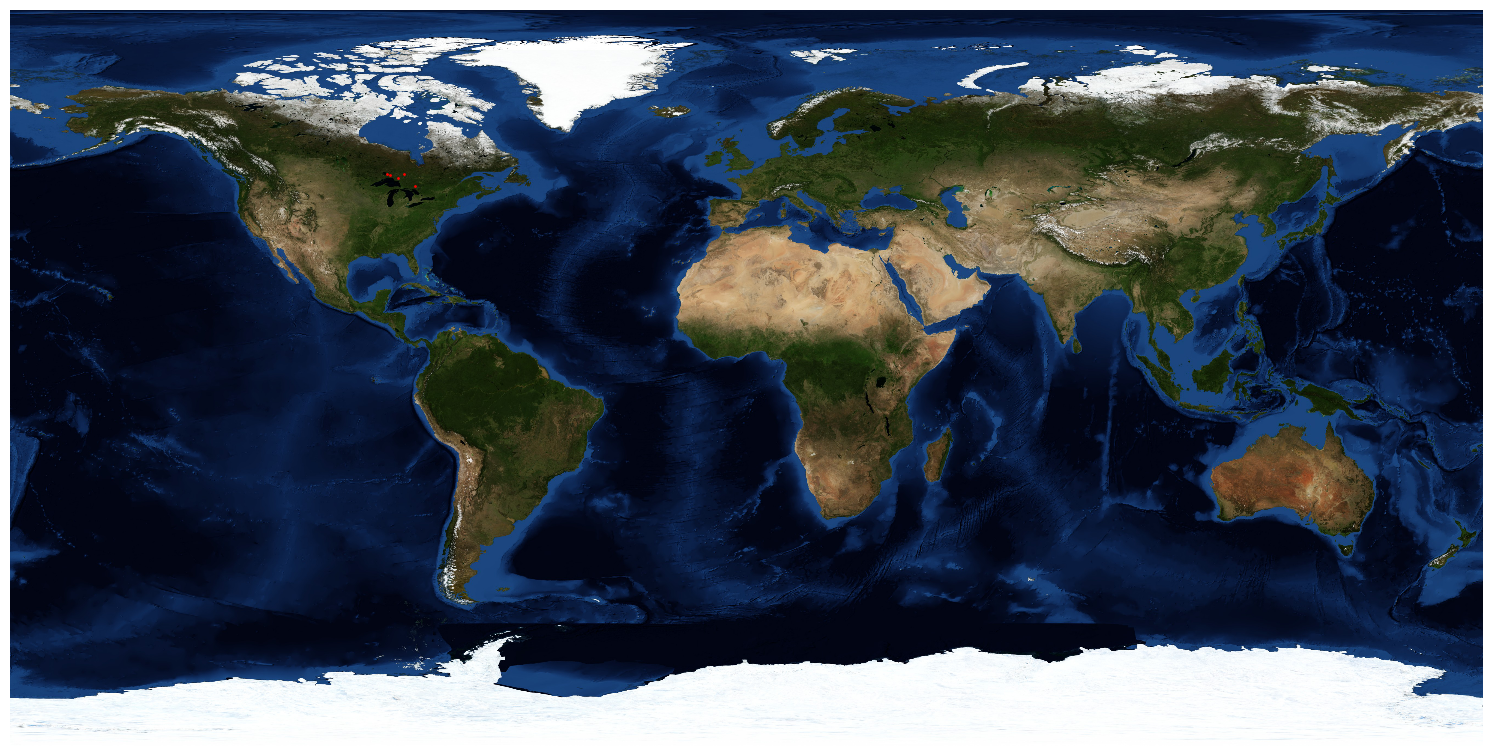

In [26]:
ds_lat_long = []
pred_lat_long = []

#convert to list
ds_lat = drills_sample["latitude"].tolist()
ds_long = drills_sample["longitude"].tolist()

for index, pred_long in enumerate(predicted5):
    ds_lat_long.append((ds_lat[index], ds_long[index]))
    pred_lat_long.append((pred_long, ds_lat[index]))
    
map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')

plt.figure(figsize=(19,20))
map.bluemarble()

for i in range(len(pred_lat_long)):
    
    x_p, y_p = map(pred_lat_long[i][0], pred_lat_long[i][1])
    x_s, y_s = map(ds_lat_long[i][0], ds_lat_long[i][1])
    map.plot(x_s,y_s,marker='x',color='Green', markersize=4)
    map.plot(x_p,y_p,marker='o',color='Red', markersize=2)

In [27]:
print("\n")
print("Thus we can see that the error is: ", round(sum(diff_sum)/len(diff_sum), 2))



Thus we can see that the error is:  -0.26


We can see how acurate is our algorithm by finding the ** coefficient of determination ** - r2_score(y_true, y_pred) 

In [28]:
first_alg = r2_score(drills_sample.longitude, predicted5)

In [29]:
print("First algorithm gives accuracy: {:.2f}".format(first_alg))

First algorithm gives accuracy: 0.40


Applying ** RANSAC (RANdom SAmple Consensus) ** method

In [30]:
ransac = RANSACRegressor()
ransac.fit(drills.drop("longitude", axis=1), drills.longitude)
print(ransac.estimator_.coef_, ransac.estimator_.intercept_)

[  1.60243380e-01   1.04511407e-02  -1.14241215e-02   8.76180371e-04
  -2.66498486e+00] 43.0540339678


In [31]:
predicted = ransac.estimator_.predict(drills.drop("longitude", axis=1))
second_alg = r2_score(drills.longitude, predicted)
print("Second algorithm gives accuracy: {:.2f}".format(second_alg))

Second algorithm gives accuracy: 0.35


Comparing one linear regression with RANSAC regression - the second algorithm gives "better" prediction

After comparison with the first algorithm we can determine which is working better:

In [32]:
print("The difference between the first and the last algorithm is:  {:.2f}%".format((first_alg-second_alg) * 100))

The difference between the first and the last algorithm is:  5.19%


** Conclution: ** The first give "better" probability - 0.40%